# Create bedGraph files of interesting gene/onts for UCSC visualization

Performing for BICCN dataset

In [137]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

In [45]:
#get counts path of ReadZs intermediate files
stem = '/oak/stanford/groups/horence/rob/readzs_fork/results/counts'

count_paths = {
 'm426003':os.path.join(stem,'20220314_MERF_UTRs_10Xv3_no_unann_filt_m426003_all_counts.txt'),
 'm427378':os.path.join(stem,'20220314_MERF_UTRs_10Xv3_no_unann_filt_m427378_all_counts.txt'),
 'm457909':os.path.join(stem,'20220314_MERF_UTRs_10Xv3_no_unann_filt_m457909_all_counts.txt'),
 'm457911':os.path.join(stem,'20220314_MERF_UTRs_10Xv3_no_unann_filt_m457911_all_counts.txt'),
}

#get mapping of cell_id to ontology information
meta_path = '/oak/stanford/groups/horence/rob/readzs_fork/MOp_10Xv3_metadata.tsv'

In [131]:
def get_gene_counts(genes, count_paths, meta_path, onts=None):
    """
    Helper function to select rows of just the gene of interest
    """
    meta_df = pd.read_csv(meta_path,sep='\t')
    cell_id_to_ann = dict(meta_df[['cell_id','subclass_label']].values)
    
    #if given a list of onts, then only include those cell_ids to map to
    if onts:
        cell_id_to_ann = {k:v for k,v in cell_id_to_ann.items() if v in onts}
    
    df = pd.DataFrame()
    for mouse,count_path in count_paths.items():
        print(mouse)
        
        #These are large CSVs, expensive to read all rows into memory at once
        df_chunks = pd.read_csv(
            count_path,
            sep='\t', 
            header=None, 
            names=['cell_id','chr','pos','strand','count','sample','annot'],
            chunksize=10000000,
        )

        for df_chunk in df_chunks:
            df_chunk['gene'] = df_chunk['annot'].str.split('_').str[1]
            gene_df = df_chunk[df_chunk['gene'].isin(genes)]
            gene_df['ont'] = gene_df['cell_id'].map(cell_id_to_ann)
            gene_df = gene_df.dropna()
            gene_df['mouse'] = mouse
            df = pd.concat((df,gene_df))

    return df


In [184]:
#Fetch counts and positions of the gene of interest (optionally restrict to specific ontologies)

#these genes come from correlating ReadZs score against punctate score
genes = [
    'Ano4', 'Bcl11b', 'Camk2d', 'Chn2', 
    'Inpp4b', 'Luzp2', 'Pou3f3', 'Ptprt', 'Sulf2',
]

count_df = get_gene_counts(genes, count_paths, meta_path)
count_df.shape

m426003
m427378
m457909
m457911


(1337018, 10)

In [185]:
count_df['mouse'].value_counts()

m426003    424875
m427378    418219
m457909    265811
m457911    228113
Name: mouse, dtype: int64

In [186]:
count_df.groupby(['ont','gene'])['count'].sum().sort_values()

ont         gene  
SMC         Sulf2          1
            Bcl11b         1
Macrophage  Ano4           1
SMC         Luzp2          1
VLMC        Bcl11b         1
                       ...  
L6 CT       Ano4       72568
L5 IT       Pou3f3     77074
            Chn2       85570
            Ptprt     106713
L6 CT       Bcl11b    112022
Name: count, Length: 173, dtype: int64

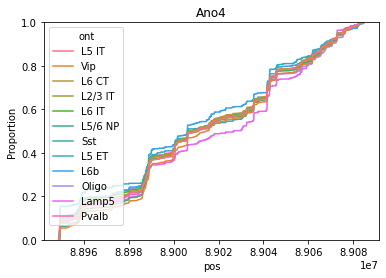

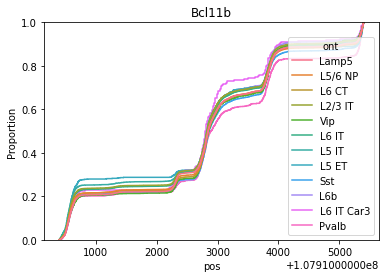

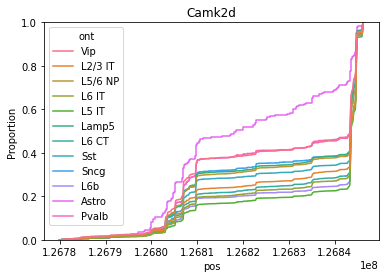

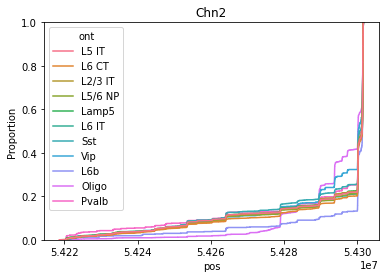

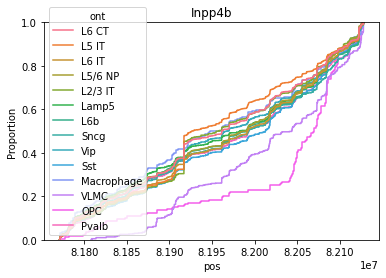

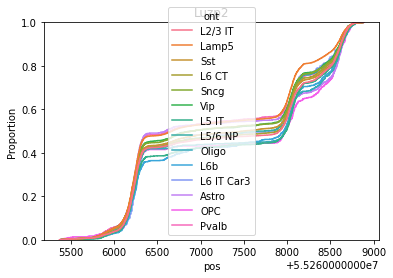

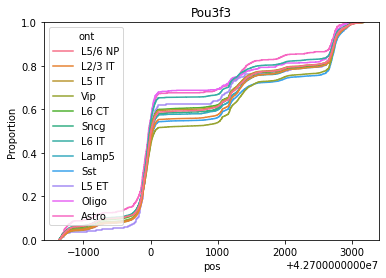

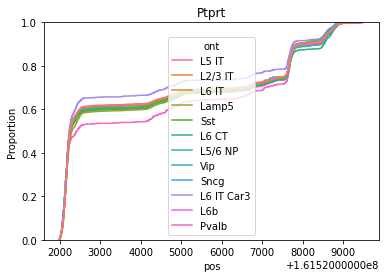

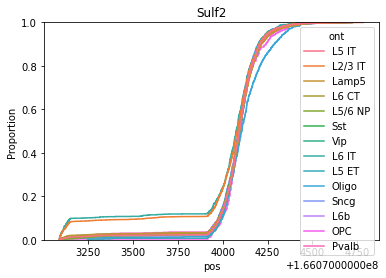

In [199]:
#Trying to prioritize interesting genes to view by UCSC and making sure to exclude low-count gene/onts
for gene,g in count_df.groupby('gene'):
        
    g = g.groupby('ont').filter(lambda x: x['count'].sum() >= 300)
    g = g.reset_index(drop=True)

    sns.ecdfplot(
        x = 'pos',
        hue = 'ont',
        data = g,
    )
    plt.title(gene)
    plt.show()
    plt.close()
    

In [207]:
#Make a separate bedgraph for each ont of all the mice counts together

#select which gene to make plots of
gene = 'Inpp4b'
num_bins = 5000

gene_count_df = count_df[count_df['gene'].eq(gene)]
#gene_count_df = count_df[count_df['gene'].eq(gene) & count_df['strand'].eq('-')] #NOTE

#framing the window
chrom = gene_count_df['chr'].values[0]
min_val = gene_count_df['pos'].min()
max_val = gene_count_df['pos'].max()
span = max_val-min_val

#reset window to not be at the very edge of the data
offset = int(0.125*span)
min_val -= offset
max_val += offset

bin_size = int((span+2*offset)/num_bins)
print(bin_size)

gene_count_df = gene_count_df.groupby('ont').filter(lambda g: g['count'].sum() >= 300)

bins = np.arange(min_val,max_val,bin_size)
bin_labels = pd.Categorical(bins[:-1])

gene_count_df['bin'] = pd.cut(gene_count_df['pos'], bins=bins)


num_onts = gene_count_df['ont'].nunique()
colors = sns.color_palette('viridis',num_onts)

created_bed_graphs = []

for i,(ont,g) in enumerate(gene_count_df.groupby('ont')):
    ont = ont.replace('/','')

    red,green,blue = colors[i]
    red,green,blue = int(256*red),int(256*green),int(256*blue)
    
    #NOTE making color black for now (let's me rearrange the plots without weird colors being adjacent)
    red,green,blue = 0,0,0

    tot_counts = g['count'].sum()

    bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
    norm_bin_counts = bin_counts/bin_counts.max()
    cs_counts = bin_counts.cumsum()/tot_counts

    #Write out the cumulative table (skip for now)
    """
    cs_out_path = '{}_{}.bedGraph'.format(gene,ont).replace(' ','_')
    created_bed_graphs.append(cs_out_path)

    with open(cs_out_path,'w') as f_out:
        f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
        f_out.write('track type=bedGraph name="cs {}" visibility=hide maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(ont,red,green,blue))

    cs_df = cs_counts.reset_index()
    cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
    cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
    cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)
    """

    #Write out the density table
    density_out_path = 'density_{}_{}.bedGraph'.format(gene,ont).replace(' ','_')
    created_bed_graphs.append(density_out_path)

    with open(density_out_path,'w') as f_out:
        f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
        f_out.write('track type=bedGraph name="{}" visibility=full maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(ont,red,green,blue))

    density_df = norm_bin_counts.reset_index()
    density_df['left'] = density_df['bin'].apply(lambda v: v.left)
    density_df['right'] = density_df['bin'].apply(lambda v: v.right)
    density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)

created_bed_graphs

89


['density_Inpp4b_L23_IT.bedGraph',
 'density_Inpp4b_L5_IT.bedGraph',
 'density_Inpp4b_L56_NP.bedGraph',
 'density_Inpp4b_L6_CT.bedGraph',
 'density_Inpp4b_L6_IT.bedGraph',
 'density_Inpp4b_L6b.bedGraph',
 'density_Inpp4b_Lamp5.bedGraph',
 'density_Inpp4b_Macrophage.bedGraph',
 'density_Inpp4b_OPC.bedGraph',
 'density_Inpp4b_Pvalb.bedGraph',
 'density_Inpp4b_Sncg.bedGraph',
 'density_Inpp4b_Sst.bedGraph',
 'density_Inpp4b_VLMC.bedGraph',
 'density_Inpp4b_Vip.bedGraph']

In [208]:
#upload the bedGraphs to AWS and get the paths so I can view in UCSC
import subprocess

for bed_graph_path in created_bed_graphs:
    subprocess.call(['aws','s3','cp',bed_graph_path,'s3://ucsc-readzs/bedGraphs/'])
    
for bed_graph_path in created_bed_graphs:
    print('https://ucsc-readzs.s3.us-west-1.amazonaws.com/bedGraphs/{}'.format(bed_graph_path))

upload: ./density_Inpp4b_L23_IT.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_L23_IT.bedGraph
upload: ./density_Inpp4b_L5_IT.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_L5_IT.bedGraph
upload: ./density_Inpp4b_L56_NP.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_L56_NP.bedGraph
upload: ./density_Inpp4b_L6_CT.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_L6_CT.bedGraph
upload: ./density_Inpp4b_L6_IT.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_L6_IT.bedGraph
upload: ./density_Inpp4b_L6b.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_L6b.bedGraph
upload: ./density_Inpp4b_Lamp5.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_Lamp5.bedGraph
upload: ./density_Inpp4b_Macrophage.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_Macrophage.bedGraph
upload: ./density_Inpp4b_OPC.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_OPC.bedGraph
upload: ./density_Inpp4b_Pvalb.bedGraph to s3://ucsc-readzs/bedGraphs/density_Inpp4b_Pvalb.bed